# Analysis of recall performance

This demo uses sample data from Morton et al. 2013. Participants completed 48 lists of 24 words each. Items were drawn from 3 categories: celebrities, landmarks, and objects. Lists were either "pure" (all the same category) or "mixed" (8 items from each category). Mixed lists had blocks of items from the same category, with length 2-6. Each of 3 sessions had 10 mixed lists and 6 pure lists (2 from each category).

Raw data are in a CSV file, which includes all study events (i.e., item presentations) and all recall events (i.e., attempted recalls). The main required fields are `trial_type` and `position`. The `trial_type` field indicates whether each trial is 'study' or 'recall'. For study events, the `position` field indicates input position (AKA serial position). For recall events, the `position` field indicates output position (that is, recall order).

## Load free recall data

In [1]:
import seaborn as sns
from psifr import fr

Set the category column to be a categorical variable with a fixed order (this mainly helps with displaying or plotting data).

In [2]:
raw = fr.sample_data("Morton2013")
raw["category"] = raw["category"].astype("category").cat.as_ordered()

Display part of the data frame. This example dataset includes standard fields that must be defined in some form (subject, list, position, trial_type, item) and other custom fields that are specific to this experiment.

In [3]:
fr.filter_data(raw, subjects=1, lists=37)

,subject,list,position,trial_type,item,item_number,session,list_type,category,response,response_time,list_category
1317,1,37,1,study,LAWN MOWER,635,3,pure,obj,2.0,0.898,obj
1318,1,37,2,study,HANDCUFFS,607,3,pure,obj,2.0,0.602,obj
1319,1,37,3,study,CAMERA,556,3,pure,obj,2.0,0.726,obj
1320,1,37,4,study,GLASS,597,3,pure,obj,3.0,0.740,obj
1321,1,37,5,study,SAUCEPAN,698,3,pure,obj,4.0,1.004,obj
1322,1,37,6,study,CACTUS,553,3,pure,obj,1.0,1.101,obj
1323,1,37,7,study,KEYS,627,3,pure,obj,4.0,1.084,obj
1324,1,37,8,study,PIE,675,3,pure,obj,2.0,0.908,obj
1325,1,37,9,study,CANDLE,557,3,pure,obj,3.0,0.786,obj
1326,1,37,10,study,DRESSER,578,3,pure,obj,4.0,0.723,obj


## Merge study and recall events

Most analyses require cross-referencing the study and recall lists. Our first step, then, is to merge these events together.

By default, study and recall events with the same subject, list, and item will be merged. All combinations within that will be kept. The `subject`, `list`, `position`, `trial_type`, and `item` columns determine how events are merged.

If an item is recalled once, then one study event will be matched with one recall event and will be labeled with `recall=True`. If an item is incorrectly recalled multiple times, then one study event will be matched with two recall events, and the second one will be labeled with `repeat=1` (both events will still have `recalled=True`). Subsequent repeats of the same item will have `repeat=2`, `repeat=3`, etc. If an item not in the list is recalled, then there will be one recall event with no corresponding study event and this event will be labeled with `intrusion=True`.

Unique study events are labeled with `study=True`. This filter excludes repeats and intrusions.

In [4]:
# list_keys: columns to include for both study and recall events
# study_keys: columns to include for study events only
data = fr.merge_free_recall(raw, list_keys=["list_type"], study_keys=["category"])

### View information about a sample list

To make it easier to understand the results of the merge, let's look at one sample list. First, we will view it with the default sorting by input position (AKA serial position). Items with no input position (i.e., intrusions) are placed at the end.

In [5]:
# cannot use query here, as that fails when referring to the list field
list1 = fr.filter_data(data, subjects=1, lists=37)
list1

,subject,list,item,input,output,study,recall,repeat,intrusion,list_type,category,prior_list,prior_input
885,1,37,LAWN MOWER,1.0,7.0,True,True,0,False,pure,obj,NaN,NaN
886,1,37,HANDCUFFS,2.0,NaN,True,False,0,False,pure,obj,NaN,NaN
887,1,37,CAMERA,3.0,NaN,True,False,0,False,pure,obj,NaN,NaN
888,1,37,GLASS,4.0,NaN,True,False,0,False,pure,obj,NaN,NaN
889,1,37,SAUCEPAN,5.0,NaN,True,False,0,False,pure,obj,NaN,NaN
890,1,37,CACTUS,6.0,NaN,True,False,0,False,pure,obj,NaN,NaN
891,1,37,KEYS,7.0,11.0,True,True,0,False,pure,obj,NaN,NaN
892,1,37,PIE,8.0,NaN,True,False,0,False,pure,obj,NaN,NaN
893,1,37,CANDLE,9.0,NaN,True,False,0,False,pure,obj,NaN,NaN
894,1,37,DRESSER,10.0,6.0,True,True,0,False,pure,obj,NaN,NaN


Because the list is represented as a merged table with both study and recall information, can also easily sort items by output position to order the rows in terms of the recall sequence.

This makes it easier to see that there were 14 correct recalls, followed by an intrusion of an item that was not in the list (BELT) and a repeat of an item that was already recalled (WATCH). Items thare were not recalled are still there, but are placed at the end because they have no defined output position (here, represented as NaN).

In [6]:
list1.sort_values("output")

,subject,list,item,input,output,study,recall,repeat,intrusion,list_type,category,prior_list,prior_input
908,1,37,WATCH,24.0,1.0,True,True,0,False,pure,obj,NaN,NaN
906,1,37,SKATEBOARD,22.0,2.0,True,True,0,False,pure,obj,NaN,NaN
902,1,37,KNIFE,18.0,3.0,True,True,0,False,pure,obj,NaN,NaN
901,1,37,TROPHY,17.0,4.0,True,True,0,False,pure,obj,NaN,NaN
907,1,37,VASE,23.0,5.0,True,True,0,False,pure,obj,NaN,NaN
894,1,37,DRESSER,10.0,6.0,True,True,0,False,pure,obj,NaN,NaN
885,1,37,LAWN MOWER,1.0,7.0,True,True,0,False,pure,obj,NaN,NaN
903,1,37,INTERCOM,19.0,8.0,True,True,0,False,pure,obj,NaN,NaN
895,1,37,MODEM,11.0,9.0,True,True,0,False,pure,obj,NaN,NaN
899,1,37,BARCODE SCANNER,15.0,10.0,True,True,0,False,pure,obj,NaN,NaN


## Analyze recall performance

While all recall attempts are represented in the merged events, often will want just the "clean" events that exclude repeats and intrusions. This is simple using the pandas `query` method. 

In [7]:
clean = data.query("study")

We can then easily calculate summary statistics such as recall percentage for each subject using `groupby` with summary statistics supported by pandas. This method easily deals with lists that vary in length; recall performance is calculated separately for each list, and the length of that specific list is taken into account when calculating the average.

Filtering the data is important for calculating recall performance. If repeat or intrusion events are included, then taking the mean of the `recalled` field will give the fraction of all events that are correct recall events. This is different than what we generally want, that is, the fraction of items correctly recalled.

For example, using the "clean" events, we can quickly calculate mean recall performance by list type (pure or mixed) and category. We first get the average for each subject.

In [8]:
perf = clean.groupby(["subject", "category", "list_type"])["recall"].mean()

To print a table with basic statistics, can first "unstack" the data. This places the list type and category indices on the columns. Then, we can use the `agg` method to calculate statistics for each column, for example mean and standard error of the mean across subjects.

In [9]:
perf.unstack("list_type").unstack("category").agg(["mean", "sem"])

list_type     mixed                          pure                    
category        cel       loc       obj       cel       loc       obj
mean       0.567604  0.516771  0.457917  0.516319  0.518403  0.527431
sem        0.014506  0.016910  0.020252  0.013552  0.016545  0.017991

Using Seaborn, we can visualize the same results. When using `groupby`, pandas will return results with a `MultiIndex`. Seaborn, however, requires us to have columns, not indices, for every variable we want to use. We can fix this using `reset_index` when passing data into Seaborn.

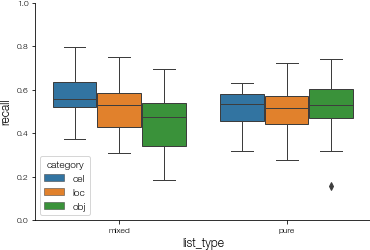

In [10]:
g = sns.boxplot(
    x="list_type", y="recall", hue="category", dodge=True, data=perf.reset_index()
)
g.set_ylim(0, 1);

### Calculate recall by list

Using pandas and seaborn, once the data are in shape we can run simple analyses with very little code. This involves specifying how to group the data and which variables we want to plot.

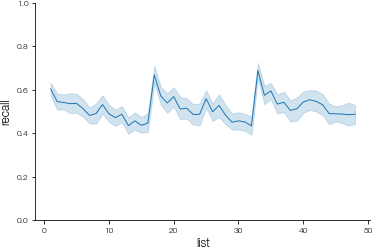

In [11]:
# calculate average recall by subject and list
perf = clean.groupby(["subject", "list"])["recall"].mean()

# plot with 95% confidence of the mean over subjects
g = sns.lineplot(x="list", y="recall", data=perf.reset_index());
g.set_ylim(0, 1);

### Recall by list type and serial position

There are special functions for common analysis, such as `spc` for calculating a serial position curve. Like before, we can use similar commands to divide the data into groups. Here, we use `groupby` to indicate groups, then use `apply` to run `spc`. Finally, `plot_spc` supports Seaborn plotting commands and sets axis labels correctly.

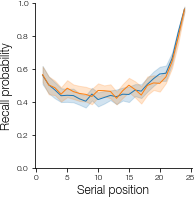

In [12]:
rec_pos = clean.groupby(["list_type"]).apply(fr.spc)
g = fr.plot_spc(rec_pos, hue="list_type")

### Recall by list type, category, and serial position

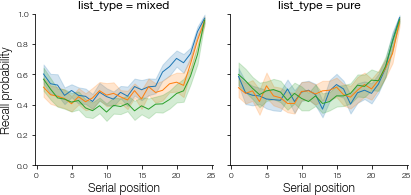

In [13]:
rec = clean.groupby(["list_type", "category"]).apply(fr.spc)
g = fr.plot_spc(rec, col="list_type", hue="category")

In [14]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 8.4.0

seaborn: 0.11.2
psifr  : 0.8.1

